In [1]:
# !pip install scipy tensorflow OpenVisus
# !pip install --upgrade numpy
# !pip install numpy==1.23.5
# !pip install keras==3.7.0

# !pip install plotly

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from tqdm.contrib.concurrent import thread_map
import OpenVisus as ov
from concurrent.futures import ThreadPoolExecutor
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable


2025-03-25 22:29:24.533281: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 22:29:24.535726: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-25 22:29:24.539436: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-25 22:29:24.550615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742941764.569754    1323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742941764.57

In [3]:
@tf.keras.utils.register_keras_serializable()
class SubpixelUpsampling(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(SubpixelUpsampling, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(SubpixelUpsampling, self).get_config()
        config.update({"scale": self.scale})
        return config

@tf.keras.utils.register_keras_serializable()
class ResizeToTarget(tf.keras.layers.Layer):
    def __init__(self, target_height, target_width, method="bilinear", **kwargs):
        super(ResizeToTarget, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width
        self.method = method

    def call(self, inputs):
        return tf.image.resize(inputs, (self.target_height, self.target_width), method=self.method)

    def get_config(self):
        config = super(ResizeToTarget, self).get_config()
        config.update({
            "target_height": self.target_height,
            "target_width": self.target_width,
            "method": self.method,
        })
        return config

# Define custom loss (needed for model deserialization)
def edge_loss(y_true, y_pred):
    sobel_true = tf.image.sobel_edges(y_true)
    sobel_pred = tf.image.sobel_edges(y_pred)
    return tf.reduce_mean(tf.abs(sobel_true - sobel_pred))

def hybrid_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    max_val = tf.reduce_max(y_true)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=max_val))
    ed_loss = edge_loss(y_true, y_pred)
    return mse_loss + ssim_loss + 0.1 * ed_loss

In [4]:
def predict_full_res(low_res_data):
    """Use the model to upscale low-resolution data to full resolution."""
    low_res_data = low_res_data[np.newaxis, ..., np.newaxis]  
    predicted_full_res = model.predict(low_res_data)[0, ..., 0]  
    return predicted_full_res

model_path = "./super_res_model.keras"  # Set this to the correct model path
model = tf.keras.models.load_model(model_path, custom_objects={'hybrid_loss': hybrid_loss})



2025-03-25 22:29:27.075624: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
def compute_risk_map(data, low_threshold=15, high_threshold=40):
    """
    Computes a binary risk map where risk=1 if relative humidity is greater than 1%
    and less than 40%.
    
    Parameters:
        data (numpy.ndarray): Full-resolution relative humidity data.
        low_threshold (float): Lower bound threshold (e.g., 1%).
        high_threshold (float): Upper bound threshold (e.g., 40%).
    
    Returns:
        numpy.ndarray: Binary risk map (1 indicates risk, 0 indicates safe).
    """
    risk_map = ((data > low_threshold) & (data < high_threshold)).astype(int)
    return risk_map


In [2]:
# Functions to change time index to actual date
def calculate_day_of_year(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    start_of_year = datetime(date.year, 1, 1)
    day_of_year = (date - start_of_year).days   
    return day_of_year
def get_timestep(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    day_of_year = calculate_day_of_year(date_str)
    total_days = 365 + (1 if (date.year % 4 == 0 and date.year % 100 != 0) or (date.year % 400 == 0) else 0)
    return f"{date.year*total_days+day_of_year}"

In [ ]:
# Load the remotely hosted, progressively encoded NEX GDDP CMIP6 dataset 
db = ov.LoadDataset('http://atlantis.sci.utah.edu/mod_visus?dataset=nex-gddp-cmip6')

time_index = 1950 * 365 + 100

full_res_data = db.read(time=time_index, quality=0)
actual_risk_map = compute_risk_map(full_res_data)

# Determine latitude and longitude arrays based on the actual full-res data shape.
nlat, nlon = full_res_data.shape
lat = np.linspace(-59.88, 89.88, nlat)
lon = np.linspace(0.125, 359.875, nlon)

In [ ]:
# Define extent for region of interest: [min_lon, max_lon, min_lat, max_lat]
extent = [lon[0], lon[-1], lat[0], lat[-1]]

# Level of quality parameters as input
quality_levels = [-2, -4, -6, -8]
predicted_risk_maps = {}

In [ ]:
# Prefict the full resolution dataset from lower input and test the risk regions

for quality in quality_levels:
    low_res_data = db.read(time=time_index, quality=quality)
    predicted_full_data = predict_full_res(low_res_data)
    risk_map = compute_risk_map(predicted_full_data)
    predicted_risk_maps[quality] = risk_map

In [ ]:
#Set reion of interests
region_slice = (slice(360, 450), slice(200, 400)) 
actual_risk_region = actual_risk_map[region_slice]

predicted_risk_regions = {}
for quality in quality_levels:
    predicted_risk_regions[quality] = predicted_risk_maps[quality][region_slice]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


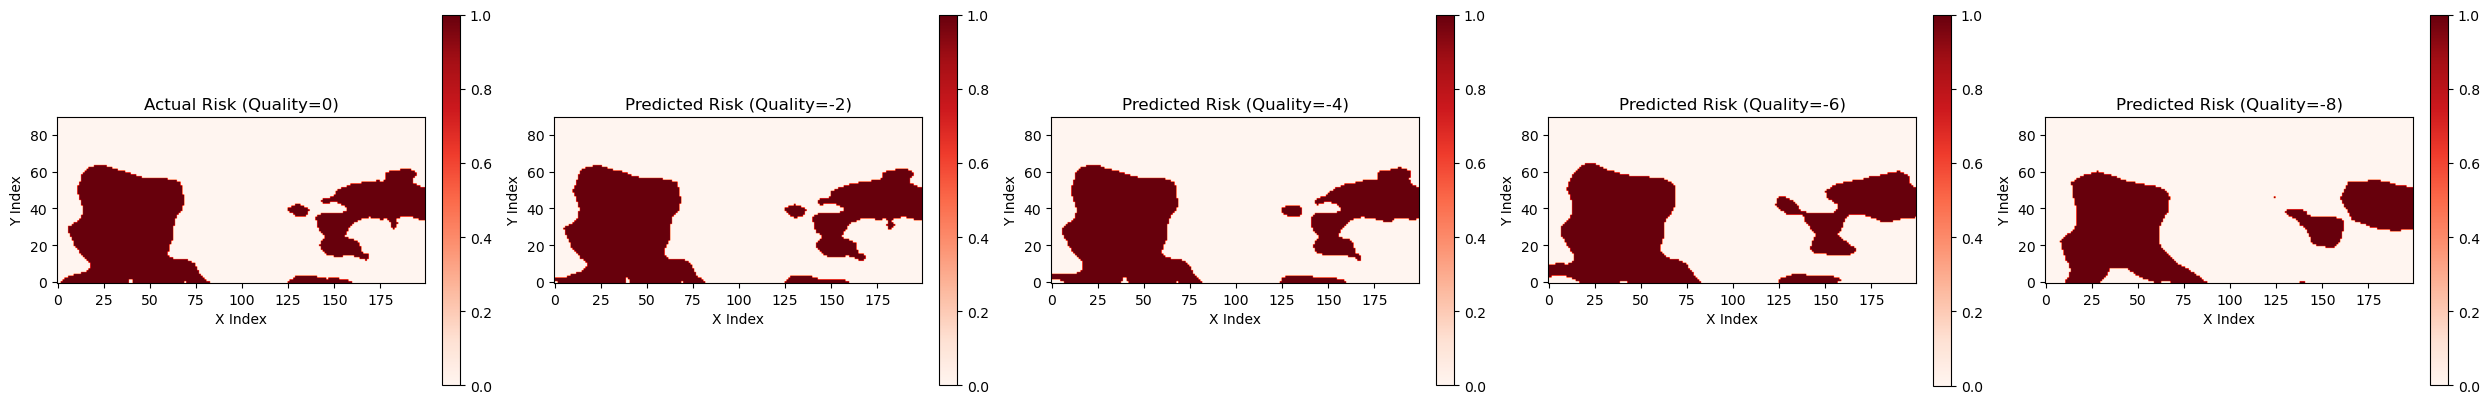

In [7]:
#Plotting using cartopy for each quality/ low-res input 
total_plots = 1 + len(quality_levels)  # One plot for actual risk and one for each predicted risk map.
fig, axs = plt.subplots(1, total_plots, figsize=(5 * total_plots, 6))

im0 = axs[0].imshow(actual_risk_region, cmap='Reds', origin='lower')
axs[0].set_title("Actual Risk (Quality=0)")
axs[0].set_xlabel("X Index")
axs[0].set_ylabel("Y Index")
fig.colorbar(im0, ax=axs[0], orientation='vertical', fraction=0.046, pad=0.04)

for i, quality in enumerate(quality_levels, start=1):
    im = axs[i].imshow(predicted_risk_regions[quality], cmap='Reds', origin='lower')
    axs[i].set_title(f"Predicted Risk (Quality={quality})")
    axs[i].set_xlabel("X Index")
    axs[i].set_ylabel("Y Index")
    fig.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Quantitative Comparison for Region [360:450, 200:400]:
Quality -2:
  Accuracy: 99.29%
  Confusion Matrix: TP=4942, TN=12930, FP=79, FN=49
  Jaccard Index: 0.975


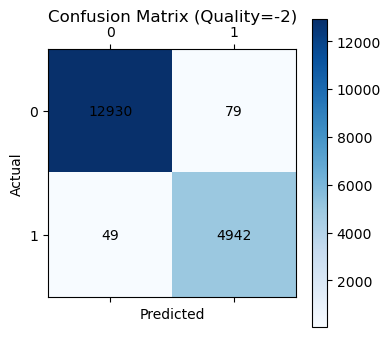

Quality -4:
  Accuracy: 99.03%
  Confusion Matrix: TP=4929, TN=12897, FP=112, FN=62
  Jaccard Index: 0.966


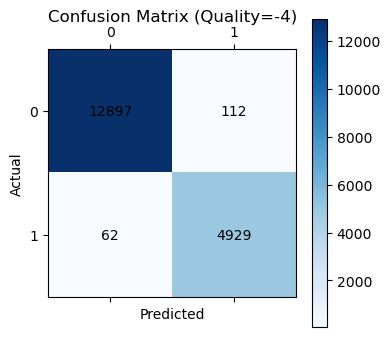

Quality -6:
  Accuracy: 96.79%
  Confusion Matrix: TP=4774, TN=12648, FP=361, FN=217
  Jaccard Index: 0.892


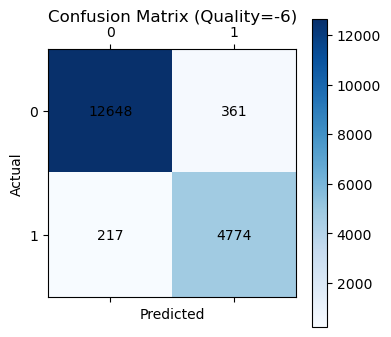

Quality -8:
  Accuracy: 91.59%
  Confusion Matrix: TP=3830, TN=12656, FP=353, FN=1161
  Jaccard Index: 0.717


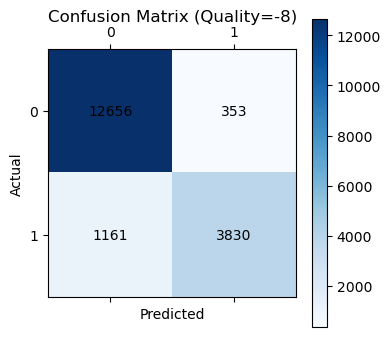

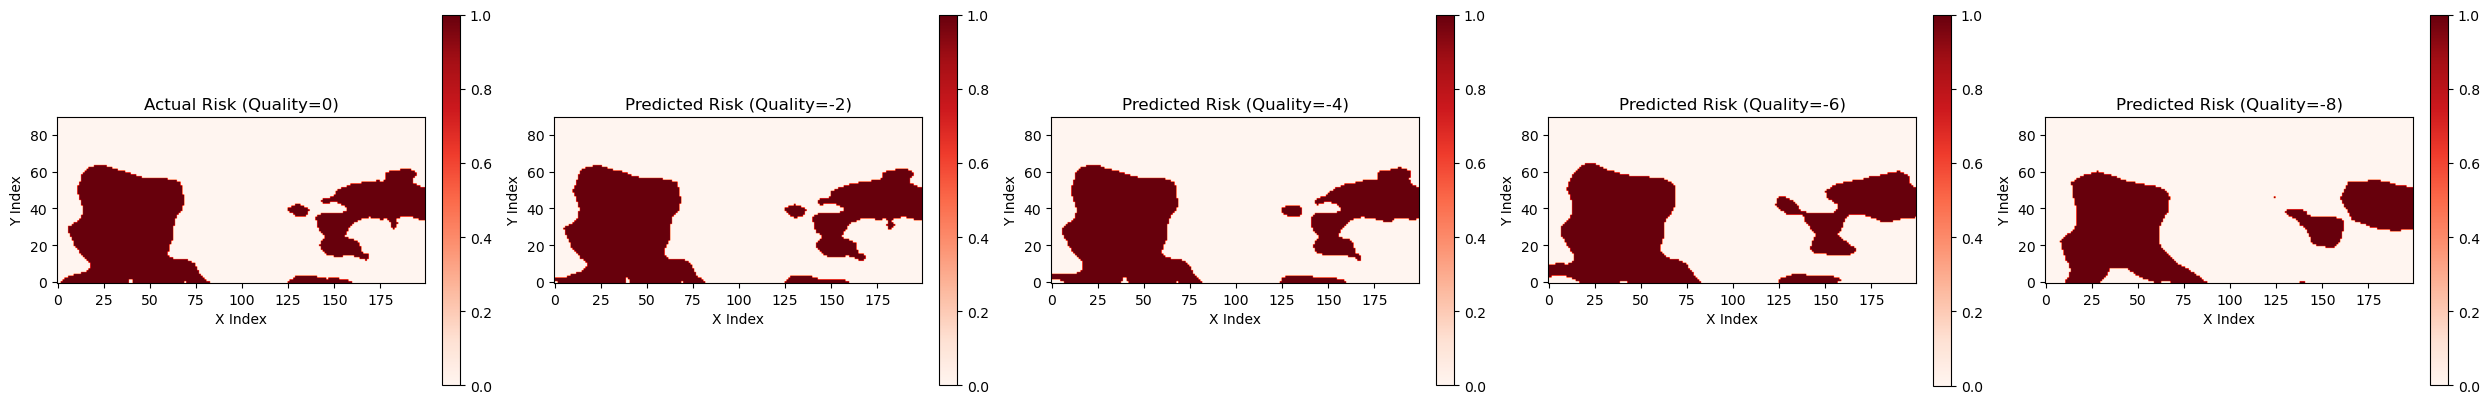

In [9]:

def plot_confusion_matrix(TP, TN, FP, FN, quality):
    """
    Plot a heatmap of the confusion matrix.
    """
    # Confusion matrix: rows: Actual [0,1], columns: Predicted [0,1]
    conf_matrix = np.array([[TN, FP],
                            [FN, TP]])
    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    plt.title(f"Confusion Matrix (Quality={quality})", pad=20)
    for (i, j), value in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{value}', va='center', ha='center', color='black')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["0", "1"])
    ax.set_yticklabels(["0", "1"])
    plt.colorbar(cax)
    plt.show()

predicted_risk_regions = {}
for quality in quality_levels:
    predicted_risk_regions[quality] = predicted_risk_maps[quality][region_slice]


total_pixels = actual_risk_region.size
for quality in quality_levels:
    pred = predicted_risk_regions[quality]
    actual = actual_risk_region
    correct_pixels = np.sum(pred == actual)
    accuracy = correct_pixels / total_pixels

    TP = np.sum((pred == 1) & (actual == 1))
    TN = np.sum((pred == 0) & (actual == 0))
    FP = np.sum((pred == 1) & (actual == 0))
    FN = np.sum((pred == 0) & (actual == 1))

    
    jaccard = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

    print(f"Quality {quality}:")
    print(f"  Accuracy: {accuracy*100:.2f}%")
    print(f"  Confusion Matrix: TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"  Jaccard Index: {jaccard:.3f}")

    plot_confusion_matrix(TP, TN, FP, FN, quality)
